In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re

C:\Users\shreejoy_tripathy\AppData\Roaming\Python\Python37\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import numpy as np
from scipy.stats import spearmanr

from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi

In [3]:
def filter_out_nan(origin):
    new_list = origin
    new_list = [x for x in new_list if str(x) != 'nan']
    return new_list

def palette_builder(cre_line, colour):
    palette = {}
    colours = filter_out_nan(colour)
    index = 0
    for cre in cre_line:
        palette[cre] = colours[index]
        index = index + 1
    return palette

In [4]:
# load all data from csvs stored in the repo

#csv file of all electrophysiology, morphology features, ion conductance, nm_id
all_features = pd.read_csv("all_features.csv", index_col=0)
#csv file of all electrophysiology, morphology features, ion conductance, nm_id, including cell type
all_features_cell_type = pd.read_csv("all_features_cell_type.csv", index_col=0)

abs_all_features = pd.read_csv("abs_all_features.csv", index_col=0)

abs_all_features_cell_type = pd.read_csv("abs_all_features_cell_type.csv", index_col=0)


#transcriptomic gene expression data by cell type
transcriptome_df = pd.read_csv("transcriptome_df.csv", index_col=0)
#transcriptomic gene expressions data with all separate cortical layers
new_transcriptome_df = pd.read_csv('sep_layer_df.csv', index_col=0)
#transcriptomic gene expression data with only cre-line
new_label_df = pd.read_csv("new_label_transcriptome_df.csv", index_col=0)

#relavtive ion conductance data for only cre-lines
cre_parameter_df = pd.read_csv("cre_parameter_df.csv", index_col=0)
#absolute ion conductance data for cell types
abs_parameter_df = pd.read_csv("abs_parameter_df.csv", index_col=0)
#relative conductance data for cell types
sep_layer_cre_parameter_df = pd.read_csv('sep_layer_cre_parameter_df.csv', index_col=0)

#csv for entrenz symbol and associated gene
entrenz_symbol_s = pd.read_csv("entrenz_symbol_s.csv", index_col=0, names = ['entrez_id', 'gene_symbol'])

#csv file about channel genes and their associated ion channels
ion_channel_genes = pd.read_csv("targets_and_families.csv", index_col=0)

#Spearman Correlation ranks at cre-line level
f = open("new_spearman_corr_ranks.json","r")
data = json.load(f)
spearman_corr_ranks = data
f.close()

#Spearman Correlation ranks for cell types and relative conductance
f = open("new_sep_spearman_corr_ranks.json","r")
data = json.load(f)
sep_spearman_corr_ranks = data
f.close()

#Spearman Correlation ranks for cell types and absolute conductance
#f = open("abs_spearman_corr_ranks.json","r")
#data = json.load(f)
#abs_spearman_corr_ranks = data
#f.close()

#cre line basic metadata
cre_line_metadata = pd.read_csv("data/cre_line_info.csv", index_col=0)




sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

#Parameter names
org = pd.read_csv("org.csv", index_col=0)
parameters = list(org['parameters'])

#Parameter names for absolute conductance
abs_parameters = list('abs_' + org['parameters'])

#6 Parameters shared by all neuronal models
shared_parameters = filter_out_nan(list(org['shared']))

#Dictionary of the related genes to the 6 parameters
related_RNA = {}
for para in shared_parameters:
    related_RNA[para] = filter_out_nan(list(org[para]))

abs_related_RNA = {}
for para in shared_parameters:
    abs_related_RNA['abs_' + para] = filter_out_nan(list(org[para]))
abs_related_RNA

#List of gene channels that are voltage gated
ion_channel_genes = ion_channel_genes[ion_channel_genes['MGI symbol'].notnull()]
gene_channel = ion_channel_genes.loc["vgic"]
gene_channel = gene_channel['MGI symbol'].values
gene_channel = list(gene_channel)

gene_channel_vgic = ion_channel_genes.loc["vgic"]
gene_channel_vgic

exclude = []
for gene in list(gene_channel_vgic['Mouse Entrez Gene']):
    if int(gene) in list(transcriptome_df.index):
        if sum(list(transcriptome_df.loc[int(gene)]))/len(list(transcriptome_df.loc[int(gene)])) < .1:
            exclude.append(gene)
for excluded_gene in exclude:
    gene_channel_vgic_filtered = gene_channel_vgic[gene_channel_vgic['Mouse Entrez Gene'] != excluded_gene]
                
gene_channel_vgic_filtered

#Set-up for palette for cell types based on Cre-line
cre_color_inc_4 = filter_out_nan(list(org['cre_line']))
cre_line_palette_inc_4 = palette_builder(cre_color_inc_4, list(org['colour']))
    
shortened_color = filter_out_nan(list(org['short']))
shortened_palette = palette_builder(shortened_color, list(org['colour']))

#import new cpm count from new dataset
new_cpm = pd.read_csv("norm_raw_counts_filtered.csv", index_col=0)

In [5]:
#import new cpm count from new dataset
tasic2016_cpm = pd.read_csv("norm_raw_counts_filtered.csv", index_col=0) # contains normalized cpm counts for just ion channel genes
tasic2016_meta = pd.read_csv("data/tasic2016/GSE71585_Clustering_Results.csv")

tasic2016_meta.head()
#set(tasic2016_meta["mouse_line"])

,sample_title,mouse_line,cre_driver_1,cre_driver_2,cre_reporter,dissection,tdTomato,pass_qc_checks,broad_type,core_intermediate,primary_type,secondary_type,aibs_vignette_id
0,Calb2_tdTpositive_cell_46,Calb2,Calb2-IRES-Cre,NaN,RCL-tdT (Ai14),upper,positive,Y,Astrocyte,core,Astro Gja1,NaN,A1631_VU
1,Calb2_tdTpositive_cell_48,Calb2,Calb2-IRES-Cre,NaN,RCL-tdT (Ai14),upper,positive,Y,Astrocyte,core,Astro Gja1,NaN,A1633_VU
2,Calb2_tdTpositive_cell_50,Calb2,Calb2-IRES-Cre,NaN,RCL-tdT (Ai14),lower,positive,Y,Astrocyte,core,Astro Gja1,NaN,A1635_VL
3,Calb2_tdTpositive_cell_53,Calb2,Calb2-IRES-Cre,NaN,RCL-tdT (Ai14),lower,positive,Y,Astrocyte,core,Astro Gja1,NaN,A1638_VL
4,Calb2_tdTpositive_cell_58,Calb2,Calb2-IRES-Cre,NaN,RCL-tdT (Ai14),lower,positive,Y,Astrocyte,core,Astro Gja1,NaN,A1643_VL


In [6]:
all_features_cell_type_Cux = all_features_cell_type[all_features_cell_type['cell_type'].str.startswith('Cux')]
all_features_cell_type_Cux['gbar_Kv3_1']

228          NaN
232     0.000007
374     0.148890
563     0.321439
623     0.000100
665     0.078343
850     0.132701
991     0.343501
1023    0.185299
1882    0.140341
Name: gbar_Kv3_1, dtype: float64

In [7]:
new_cpm_Cux = new_cpm.filter(regex='Cux2.*positive', axis=1)

In [8]:
new_cpm_Cux.loc['Kcnc1']

Cux2_tdTpositive_cell_1      2.625628
Cux2_tdTpositive_cell_2      4.526880
Cux2_tdTpositive_cell_3      4.151761
Cux2_tdTpositive_cell_4      0.614982
Cux2_tdTpositive_cell_5      2.983566
                               ...   
Cux2_tdTpositive_cell_120    2.225085
Cux2_tdTpositive_cell_121    4.102117
Cux2_tdTpositive_cell_122    0.349797
Cux2_tdTpositive_cell_123    3.056651
Cux2_tdTpositive_cell_124    0.000000
Name: Kcnc1, Length: 124, dtype: float64

In [9]:
#calculate the standard deviation and sem
def cal_std_sem(index_name):
    index_name = list(org['parameters'])
    index_name.append('cell_type')
    stdcal = all_features_cell_type[all_features_cell_type['gbar_Ih'].notna()]
    stdcal = stdcal[stdcal['cell_type'] != 'False']
    stdcal = stdcal[index_name]
    std = stdcal.groupby('cell_type').std()
    sem = stdcal.groupby('cell_type').sem()
    std.rename(index = {"Htr3a-Cre_NO152__L6__exc": "Htr3a-Cre_NO152__L5-L6__exc", 
                         "Scnn1a-Tg3-Cre__L4__exc":"Scnn1a-Tg3-Cre__L2/3-L4__exc", "Sst-IRES-Cre__L2/3__inh":"Sst-IRES-Cre__L1-L2/3__inh"}, 
                                     inplace = True) 
    sem.rename(index = {"Htr3a-Cre_NO152__L6__exc": "Htr3a-Cre_NO152__L5-L6__exc", 
                         "Scnn1a-Tg3-Cre__L4__exc":"Scnn1a-Tg3-Cre__L2/3-L4__exc", "Sst-IRES-Cre__L2/3__inh":"Sst-IRES-Cre__L1-L2/3__inh"}, 
                                     inplace = True) 
    return sem, std

#set sem and std to the values for standard deviation and sem for relative
sem, std = cal_std_sem(parameters)

#set sem and std to the values for standard deviation and sem for absolute
abs_sem, abs_std = cal_std_sem(abs_parameters)

In [10]:
def create_cre_conductance(parameter_type, df):
    cre_parameter_df_spec = df[[parameter_type]]
    cre_conductance_filtered = cre_parameter_df_spec[cre_parameter_df_spec[parameter_type].notna()]
    cre_conductance_filtered = cre_conductance_filtered.loc[cre_color_inc_4 , : ]
    return cre_conductance_filtered

def create_gene_spec_filtered(gene_symbol_list):

    gene_symbol_list_curr = gene_symbol_list
    
    new_df = gene_channel_vgic[gene_channel_vgic['MGI symbol'].isin(gene_symbol_list_curr)]
    gene_id_list = list(map(int, new_df['Mouse Entrez Gene'].values))

    gene_spec = transcriptome_df.filter(items = gene_id_list, axis = 0)

    gene_spec_filtered = gene_spec.filter(items = cre_color_inc_4, axis = 1)
    gene_spec_filtered = gene_spec_filtered.transpose()
    return gene_spec_filtered, gene_id_list

def rename_graph_spec(graph_spec):
    renaming_index = palette_builder(cre_color_inc_4, shortened_color)
    graph_spec.rename(index = renaming_index, 
                                 inplace = True)

In [11]:
def create_graph_spec(parameter_type, gene_symbol_list, df):
    cre_conductance_filtered = create_cre_conductance(parameter_type, df)
   
    gene_spec_filtered, gene_id = create_gene_spec_filtered(gene_symbol_list)
    
    graph_spec = cre_conductance_filtered.merge(gene_spec_filtered, left_index = True, right_index = True)
    
    rename_graph_spec(graph_spec)

    return graph_spec

In [12]:
gene_symbol_list = ['Kcnc1', 'Kcnc2']
gene_spec_filtered, gene_id_list = create_gene_spec_filtered(gene_symbol_list)
shortened_color
create_graph_spec('gbar_Kv3_1', gene_symbol_list, sep_layer_cre_parameter_df)
#gene_channel_vgic.head()

,gbar_Kv3_1,16502,268345
Htr3a L2/3,0.235402,6.462288,4.488584
Htr3a L5,0.638604,6.628302,6.410418
Nr5a1 L4,0.126182,4.253329,5.948370
Ntsr1 L6,0.149601,2.239168,0.332700
Pvalb L2/3,0.693312,9.539327,9.454763
Pvalb L4,1.121246,9.610216,9.778576
Pvalb L5,1.266772,9.321005,10.153407
Pvalb L6,1.250779,9.395449,10.692092
Rbp4 L4,0.190676,4.345955,5.251131
Rbp4 L5,0.124294,2.214520,3.003016


In [13]:
#Graphing scatterplot of conductance and transcriptomics
def predict(parameter_type, gene_symbol, df, xlabel, ylabel, 
                                show_errorbars = True,
                                show_legend = True, 
                                show_best_line = True, 
                                poly_deg = 2 # degree of polynomial for fit
                               ):
    gene_id = int(gene_channel_vgic[gene_channel_vgic['MGI symbol'] == gene_symbol]['Mouse Entrez Gene'])
    graph_spec = create_graph_spec(parameter_type, gene_symbol, df) 

    # get standard errors
    std_cre = sem.loc[cre_color_inc_4,:]
    errors = std_cre[parameter_type]
    inv_errors = 1/errors
    
    # set up plot parameters
#     plt.figure(figsize=(7, 7))   
#     mpl.rcParams['pdf.fonttype'] = 42
#     mpl.rcParams['ps.fonttype'] = 42
#     plt.rcParams['svg.fonttype'] = 'none'
    
    graph_spec.sort_values(by=[gene_id], inplace = True)
    mini = graph_spec.iloc[0, :][gene_id]
    # mini = 0
    maxi = graph_spec.iloc[14, :][gene_id]
    
    graph_spec = create_graph_spec(parameter_type, gene_symbol, df) 
    
    # best fit line
    if(show_best_line):
        #z = np.polyfit(x=graph_spec[gene_id], y=graph_spec[parameter_type], deg=poly_deg, w=inv_errors)
        z = np.polyfit(x=graph_spec[gene_id], y=graph_spec[parameter_type], deg=poly_deg)
        #z = np.polyfit(x= graph_spec[gene_id], y=np.log(graph_spec[parameter_type]), deg=1)
        p = np.poly1d(z)
        xp = np.linspace(mini, maxi, 100)
        #_ = plt.plot(xp, np.exp(p(xp)), '-', zorder=1)
        _ = plt.plot(xp, p(xp), '-', zorder=1)
        
        formula = '' + parameter_type + ' ~ ' + gene_symbol +  ' + 1'
        print(formula)
        
        graph_spec_new = graph_spec.copy()
        graph_spec_new.index = range(15)

        graph_spec_new.rename(columns={gene_id: gene_symbol}, inplace= True)

        gamma_model = smf.glm(formula = formula, data = graph_spec_new, family=sm.families.Gamma())
        gamma_results = gamma_model.fit()
        xp_df = pd.DataFrame(data = {gene_symbol : xp})
        predicted_vals = gamma_results.predict(xp_df)
        _ = plt.plot(xp, predicted_vals, '-', zorder=1)
#         predicted_vals = gamma_results.predict(graph_spec_new[gene_symbol])
#         _ = plt.plot(graph_spec_new[gene_symbol], predicted_vals, '.', zorder=1)
        predicted = gamma_results.predict(new_cpm_Cux.loc[gene_symbol])

        
    # plot data points
    ax = sns.scatterplot(x=gene_id, y=parameter_type, hue=shortened_color, data=graph_spec, s = 100, palette=shortened_palette, zorder=3)
    
    # legend handling
    if (show_legend):
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Cell Types", fontsize=15)
    else:
        ax.get_legend().remove()
    
    
#     plt.rcParams['font.family'] = 'sans-serif'
#     plt.rcParams['font.sans-serif'] = ['Tahoma']
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

#     ax.xaxis.label.set_size(12)
#     ax.yaxis.label.set_size(12)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    
    if (show_errorbars):
        # Find the x,y coordinates for each point for errorbar plotting
        x_coords = []
        y_coords = []
        for point_pair in ax.collections:
            for x, y in point_pair.get_offsets():
                x_coords.append(x)
                y_coords.append(y)

        ax.errorbar(x_coords, y_coords, yerr=errors, fmt=' ', alpha=.5 ,zorder=2)
    return ax, predicted
#     return(plt)


In [14]:
'+'.join(['a', 'b'])

'a+b'

In [15]:
from functools import reduce #python 3

def get_cond_stat_models(parameter_type, gene_symbol_list, df, log=False):
    
    gene_id_list = create_gene_spec_filtered(gene_symbol_list)[1]
    print(gene_id_list)
    #gene_id = int(gene_channel_vgic[gene_channel_vgic['MGI symbol'] == gene_symbol]['Mouse Entrez Gene'])

    graph_spec = create_graph_spec(parameter_type, gene_symbol_list, df) 
    
#     z = np.polyfit(x=graph_spec[gene_id], y=graph_spec[parameter_type], deg=poly_deg)
#     #z = np.polyfit(x= graph_spec[gene_id], y=np.log(graph_spec[parameter_type]), deg=1)
#     p = np.poly1d(z)
#     xp = np.linspace(mini, maxi, 100)
#     #_ = plt.plot(xp, np.exp(p(xp)), '-', zorder=1)
#     _ = plt.plot(xp, p(xp), '-', zorder=1)

    gene_string = ' + '.join(gene_symbol_list)
    formula = '' + parameter_type + ' ~ ' + gene_string +  ' + 1'


    graph_spec.columns = flatten([graph_spec.columns[0], gene_symbol_list])
    
    if log:
        graph_spec[parameter_type] = np.log10(graph_spec[parameter_type])
    
    model = smf.ols(formula = formula, data = graph_spec)
    fit_model = model.fit()

    link_fxn = sm.families.links.log
    gamma_model = smf.glm(formula = formula, data = graph_spec, family=sm.families.Gaussian(link=link_fxn))
    fit_model = gamma_model.fit()
    return(fit_model)
    
def get_gene_exp_cond_predictions(gene_exp_mat, fit_model, gene_symbol_list, log = False):
    pred_data = gene_exp_mat.filter(items = gene_symbol_list, axis = 0).transpose()
    predicted = fit_model.predict(pred_data)
    #print(predicted)
    if log:
        predicted = np.power(10, predicted)
    return predicted

def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

In [16]:
conductance = 'gbar_SK'
gene_symbol_list = ['Kcnn1', 'Kcnn2', 'Kcnn3']
fit_model = get_cond_stat_models(conductance, gene_symbol_list, sep_layer_cre_parameter_df, log = False)
print(fit_model.summary())
predictions = get_gene_exp_cond_predictions(new_cpm, fit_model,  gene_symbol_list, log = False)
print(predictions)

[84036, 140492, 140493]
                 Generalized Linear Model Regression Results                  
Dep. Variable:                gbar_SK   No. Observations:                   15
Model:                            GLM   Df Residuals:                       11
Model Family:                Gaussian   Df Model:                            3
Link Function:                    log   Scale:                      0.00018982
Method:                          IRLS   Log-Likelihood:                 44.987
Date:                Wed, 26 Feb 2020   Deviance:                    0.0020880
Time:                        16:52:21   Pearson chi2:                  0.00209
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.8329      1

C:\Users\shreejoy_tripathy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.


In [17]:
# run all predictions for all conductances on tasic2016 data
df = pd.DataFrame()
for cond in related_RNA.keys():
    gene_symbol_list = related_RNA[cond][0:2]
    #gene_symbol_list = [related_RNA[cond][0]]
    print(gene_symbol_list)
    fit_model = get_cond_stat_models(cond, gene_symbol_list, sep_layer_cre_parameter_df, log = False)
    predictions = get_gene_exp_cond_predictions(new_cpm, fit_model, gene_symbol_list, log = False)
    df[cond] = predictions
    
df.head()   

C:\Users\shreejoy_tripathy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.


['Kcnc1', 'Kcnc2']
[16502, 268345]
['Kcnd1', 'Kcnd2']
[16506, 16508]
['Kcnn1', 'Kcnn2']
[84036, 140492]
['Hcn1', 'Hcn2']
[15165, 15166]
['Cacna1a', 'Cacna1b']
[12286, 12287]
['Cacna1g', 'Cacna1h']
[12291, 58226]


,gbar_Kv3_1,gbar_K_T,gbar_SK,gbar_Ih,gbar_Ca_HVA,gbar_Ca_LVA
Calb2_tdTpositive_cell_1,0.055628,0.018726,0.023689,0.000255,0.000413,0.004401
Calb2_tdTpositive_cell_2,0.241403,0.002721,0.004060,0.000930,0.000413,0.004543
Calb2_tdTpositive_cell_3,0.050058,0.014995,0.003441,0.000976,0.000413,0.005022
Calb2_tdTpositive_cell_4,0.237045,0.002721,0.001585,0.000956,0.000416,0.004543
Calb2_tdTpositive_cell_5,0.027716,0.025127,0.001617,0.000958,0.000413,0.002650


In [32]:
# all_features_cell_type[all_features_cell_type['gbar_Ih'] > 0 ].head()
# cre_line_metadata.head()

all_cell_features_annotated = all_features_cell_type.merge(cre_line_metadata, left_on = 'cell_type', right_on = 'cre_line', how = 'left')
all_cell_features_annotated.head()
all_cell_features_annotated.rename(columns = {'subclass' : 'mouse_line' }, inplace=True)
all_cell_features_annotated['source'] = 'Ephys'

all_cell_features_annotated['mouse_line']

all_cell_features_annotated.loc[all_cell_features_annotated.cre_line == 'Cux2-CreERT2', 'mouse_line'] = 'Cux2'
all_cell_features_annotated.loc[all_cell_features_annotated.cre_line == 'Scnn1a-Tg3-Cre', 'mouse_line'] = 'Scnn1a-Tg3'


In [33]:
all_cell_features_annotated.head()

,cell_type,gbar_Im,gbar_Ih,gbar_NaTs,gbar_Nap,gbar_K_P,gbar_K_T,gbar_SK,gbar_Kv3_1,gbar_Ca_HVA,...,gbar_Im_v2,cre_line,dendrite_type,short,colour,class,mouse_line,subclass_colour,class_colour,source
0,False,0.001732,0.001028,5.703488,0.000198,0.095741,0.02296,0.001076,0.481481,0.000315,...,NaN,Human,spiny,NaN,NaN,NaN,NaN,NaN,NaN,Ephys
1,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Human,spiny,NaN,NaN,NaN,NaN,NaN,NaN,Ephys
2,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Ndnf-IRES2-dgCre,aspiny,NaN,NaN,NaN,NaN,NaN,NaN,Ephys
3,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Htr3a-Cre_NO152,aspiny,NaN,NaN,NaN,NaN,NaN,NaN,Ephys
4,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Scnn1a-Tg3-Cre,spiny,NaN,NaN,NaN,Scnn1a-Tg3,NaN,NaN,Ephys


In [34]:
new_df = tasic2016_meta.merge(df, left_on = 'sample_title', right_index = True)
#new_df.loc[new_df['mouse_line'] == 'Pvalb']
new_df['source'] = 'mRNA'
new_df.head()

,sample_title,mouse_line,cre_driver_1,cre_driver_2,cre_reporter,dissection,tdTomato,pass_qc_checks,broad_type,core_intermediate,primary_type,secondary_type,aibs_vignette_id,gbar_Kv3_1,gbar_K_T,gbar_SK,gbar_Ih,gbar_Ca_HVA,gbar_Ca_LVA,source
0,Calb2_tdTpositive_cell_46,Calb2,Calb2-IRES-Cre,NaN,RCL-tdT (Ai14),upper,positive,Y,Astrocyte,core,Astro Gja1,NaN,A1631_VU,0.031373,0.002721,0.233694,0.000976,0.000413,0.004543,mRNA
1,Calb2_tdTpositive_cell_48,Calb2,Calb2-IRES-Cre,NaN,RCL-tdT (Ai14),upper,positive,Y,Astrocyte,core,Astro Gja1,NaN,A1633_VU,0.026190,0.002721,0.029979,0.000976,0.000413,0.004543,mRNA
2,Calb2_tdTpositive_cell_50,Calb2,Calb2-IRES-Cre,NaN,RCL-tdT (Ai14),lower,positive,Y,Astrocyte,core,Astro Gja1,NaN,A1635_VL,0.023797,0.002721,1.274141,0.000976,0.000413,0.004543,mRNA
3,Calb2_tdTpositive_cell_53,Calb2,Calb2-IRES-Cre,NaN,RCL-tdT (Ai14),lower,positive,Y,Astrocyte,core,Astro Gja1,NaN,A1638_VL,0.026147,0.002721,0.901741,0.000976,0.000413,0.004543,mRNA
4,Calb2_tdTpositive_cell_58,Calb2,Calb2-IRES-Cre,NaN,RCL-tdT (Ai14),lower,positive,Y,Astrocyte,core,Astro Gja1,NaN,A1643_VL,0.023828,0.002721,0.111005,0.000976,0.000413,0.004543,mRNA


In [35]:
keep_cre_lines = list(set(cre_line_metadata['subclass'].values))
keep_cre_lines.append('Cux2')
print(keep_cre_lines)

['Nr5a1', 'Ntsr1', 'Scnn1a-Tg2', 'Pvalb', 'Scnn1a-Tg3', 'Htr3a', 'Rbp4', 'Sst', 'Cux2']


In [36]:
new_df_filt = new_df.loc[(new_df['tdTomato'] == 'positive') &  
                         (new_df['pass_qc_checks'] == 'Y') &  
                         (new_df['broad_type'].isin(['GABA-ergic Neuron', 'Glutamatergic Neuron'])) &
                         (new_df['mouse_line'].isin(keep_cre_lines)) &
                         (new_df['aibs_vignette_id'] != 'N/A') &
                         (new_df['dissection'] != 'L6b') 
                        ]

# bind rows of ME and T dfs
new_new_df = all_cell_features_annotated.append(new_df_filt)
#new_new_df.loc[new_df['mouse_line'] == 'Rbp4']['gbar_Kv3_1']

C:\Users\shreejoy_tripathy\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [37]:
new_new_df.shape

(3161, 42)

[Text(0, 0.5, 'Kv3.1 Conductance'), Text(0.5, 0, 'Cell type (mouse cre-line)')]

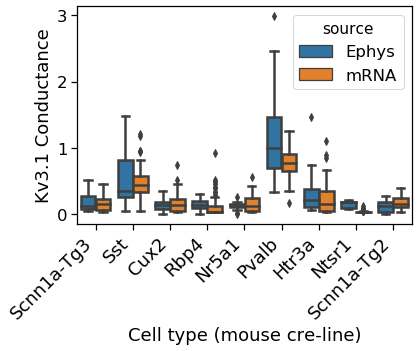

In [41]:
cond = "gbar_Kv3_1"
ax = sns.boxplot(x="mouse_line", y=cond, hue = 'source', data=new_new_df)


ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium'

)
ax.set(xlabel='Cell type (mouse cre-line)', ylabel='Kv3.1 Conductance')
#ax.set(yscale = "log")
# ax.set_ylim([0, 3])

In [487]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

    mouse_line source  gbar_Kv3_1   gbar_SK  gbar_K_T       gbar_Ih  \
0         Cux2     ME    0.140341  0.002418  0.000676  8.386369e-05   
1         Cux2      T    0.141879  0.002265  0.019887  8.983328e-04   
2        Htr3a     ME    0.215882  0.000534  0.016412  8.870448e-05   
3        Htr3a      T    0.148649  0.060150  0.011738  3.936185e-04   
4        Nr5a1     ME    0.143941  0.001160  0.005056  7.143385e-07   
5        Nr5a1      T    0.125028  0.001634  0.025305  8.268629e-04   
6        Ntsr1     ME    0.180163  0.012147  0.002921  3.645626e-05   
7        Ntsr1      T    0.025494  0.020407  0.015795  4.022059e-04   
8        Pvalb     ME    1.004592  0.000002  0.042747  2.750973e-04   
9        Pvalb      T    0.771883  0.001853  0.010433  2.887561e-04   
10        Rbp4     ME    0.137254  0.000738  0.000116  3.744528e-04   
11        Rbp4      T    0.028270  0.012686  0.018117  4.136404e-04   
12  Scnn1a-Tg2     ME    0.123753  0.012882  0.000018  1.405554e-04   
13  Sc

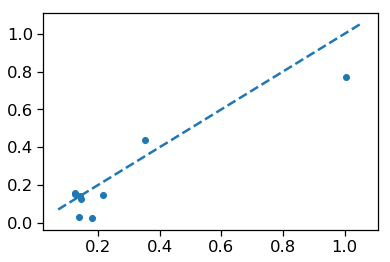

(0.9391497735617406, 0.0001723764357894579)
0.07641647467456807
gbar_K_T
   mouse_line        ME         T
0        Cux2  0.000676  0.019887
1       Htr3a  0.016412  0.011738
2       Nr5a1  0.005056  0.025305
3       Ntsr1  0.002921  0.015795
4       Pvalb  0.042747  0.010433
5        Rbp4  0.000116  0.018117
6  Scnn1a-Tg2  0.000018  0.015760
7  Scnn1a-Tg3  0.000495  0.019444
8         Sst  0.022917  0.017112


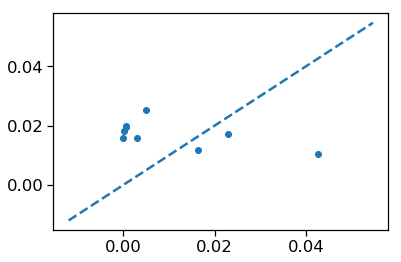

(-0.6283467606264529, 0.06994272481826465)
0.01203414166121701
gbar_SK
   mouse_line        ME         T
0        Cux2  0.002418  0.002265
1       Htr3a  0.000534  0.060150
2       Nr5a1  0.001160  0.001634
3       Ntsr1  0.012147  0.020407
4       Pvalb  0.000002  0.001853
5        Rbp4  0.000738  0.012686
6  Scnn1a-Tg2  0.012882  0.009803
7  Scnn1a-Tg3  0.001901  0.001634
8         Sst  0.000161  0.001634


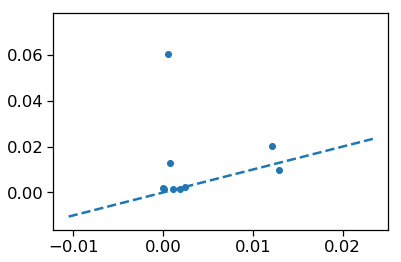

(0.03650419356588527, 0.9257167984420125)
0.008428312962721347
gbar_Ih
   mouse_line            ME         T
0        Cux2  8.386369e-05  0.000898
1       Htr3a  8.870448e-05  0.000394
2       Nr5a1  7.143385e-07  0.000827
3       Ntsr1  3.645626e-05  0.000402
4       Pvalb  2.750973e-04  0.000289
5        Rbp4  3.744528e-04  0.000414
6  Scnn1a-Tg2  1.405554e-04  0.000454
7  Scnn1a-Tg3  1.474632e-04  0.000723
8         Sst  6.980458e-04  0.000395


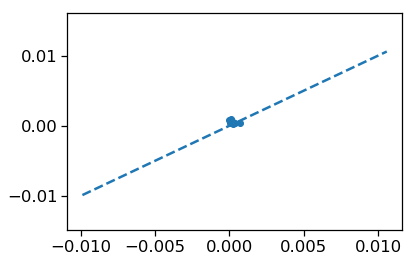

(-0.4577859120469495, 0.21530639703029197)
0.000288655930042202
gbar_Ca_HVA
   mouse_line        ME         T
0        Cux2  0.000207  0.000424
1       Htr3a  0.000360  0.000413
2       Nr5a1  0.000449  0.000426
3       Ntsr1  0.000722  0.000412
4       Pvalb  0.000480  0.000410
5        Rbp4  0.000356  0.000419
6  Scnn1a-Tg2  0.000629  0.000479
7  Scnn1a-Tg3  0.000292  0.000417
8         Sst  0.000544  0.000413


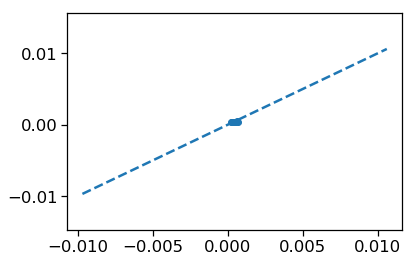

(0.2671823686721847, 0.4870489466253124)
0.00010595018613306718
gbar_Ca_LVA
   mouse_line        ME         T
0        Cux2  0.001927  0.004543
1       Htr3a  0.001799  0.004543
2       Nr5a1  0.003322  0.004567
3       Ntsr1  0.003006  0.004543
4       Pvalb  0.005778  0.004543
5        Rbp4  0.006425  0.004543
6  Scnn1a-Tg2  0.001051  0.004626
7  Scnn1a-Tg3  0.004683  0.004543
8         Sst  0.004767  0.004543


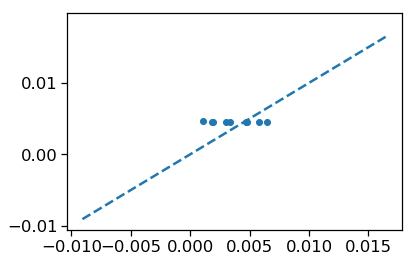

(-0.5323328467810668, 0.14011128790560223)
0.0017010569132733292


In [490]:
from scipy import stats
## need to plot medians or means to see what is going on
from scipy.stats.stats import pearsonr   
from sklearn import metrics

agg_metric = 'median'
new_new_df_2 = new_new_df.groupby(['mouse_line', 'source']).agg({'gbar_Kv3_1': agg_metric, 'gbar_SK': agg_metric,
                                                  'gbar_K_T': agg_metric, 'gbar_Ih': agg_metric,
                                                     'gbar_Ca_HVA': agg_metric, 'gbar_Ca_LVA': agg_metric}).reset_index()
    
#keep_mouse_lines = ['Cux2', 'Nr5a1', 'Ntsr1', 'Pvalb', 'Rbp4', 'Sst', 'Htr3a', 'Scnn1a-Tg2']
keep_mouse_lines = keep_cre_lines
new_new_df_3 = new_new_df_2.loc[new_new_df_2['mouse_line'].isin(keep_mouse_lines)]
print(new_new_df_3)

#print(new_new_df)
for cond in related_RNA.keys():
    print(cond)
    me_vals = new_new_df_3.loc[new_new_df_3['source'] == 'ME'][cond].to_numpy()
    t_vals = new_new_df_3.loc[new_new_df_3['source'] == 'T'][cond].to_numpy()
    mouse_line = new_new_df_3.loc[new_new_df_3['source'] == 'ME']['mouse_line'].values.tolist()
    temp_df = pd.DataFrame({'mouse_line' : mouse_line, 'ME': me_vals, 'T': t_vals})
    print(temp_df)
    
    actual_cond_vals = temp_df['ME']
    pred_cond_vals = temp_df['T']
    plt.scatter(actual_cond_vals, pred_cond_vals)
    abline(1, 0)
    plt.show()
#     ax = sns.scatterplot(x="ME", y="T",
#                      data=temp_df)
    print(pearsonr(stats.zscore(actual_cond_vals), stats.zscore(pred_cond_vals)))
    #print()
    print(metrics.median_absolute_error(actual_cond_vals, pred_cond_vals- np.mean(pred_cond_vals) + np.mean(actual_cond_vals)))
    
    # })
# m.name = 'MEDIAN'

# print df.join(m, on=['COL1', 'COL2'])

TypeError: only list-like objects are allowed to be passed to isin(), you passed a [str]

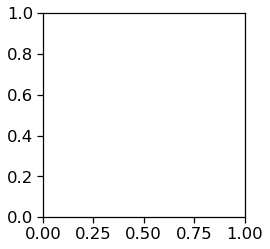

In [184]:
import matplotlib.gridspec as gridspec
# Initialize the grid with 3 rows and 3 columns
ncols = 3
nrows = 3
fig = plt.figure(figsize = (13, 14))

grid = gridspec.GridSpec(nrows, ncols,
                left=0.1, bottom=0.15, right=0.94, top=0.94, wspace=0.45, hspace=0.45)


ax1 = fig.add_subplot(grid[0, 0])
ax1, predicted = predict('gbar_SK', 'Kcnn2', sep_layer_cre_parameter_df, 'Kcnn2 mRNA ($log_2$ CPM+1)', 'Kv3.1 Conductance (pS/$\mu m^2$)', show_legend= False, poly_deg=2)


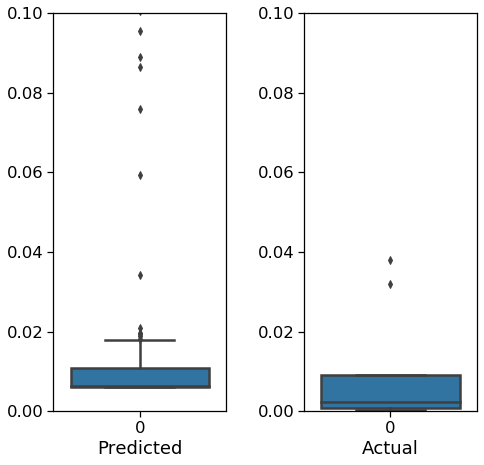

In [29]:
ncols = 2
nrows = 1
fig = plt.figure(figsize = (7, 7))

grid = gridspec.GridSpec(nrows, ncols,
                left=0.1, bottom=0.15, right=0.94, top=0.94, wspace=0.45, hspace=0.45)
actual = list(all_features_cell_type_Cux['gbar_SK'].dropna())


ax1 = fig.add_subplot(grid[0, 0])
ax1 = sns.boxplot(data = predicted).set(xlabel='Predicted', ylim=(0,0.1))
ax2 = fig.add_subplot(grid[0, 1])
ax2 = sns.boxplot(data = actual).set(xlabel='Actual', ylim=(0,0.1))